# Setup

In [1]:
! pip install torchinfo

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
import torchinfo
from glob import glob
import fnmatch
import cv2

# Load the data

Load all images in bulk.

In [3]:
image_patches = glob("../input/breast-histopathology-images/*/*/*_idx5_*.png",
                     recursive = True)

# Data partitioning

Separate the class 0 images from the class 1 images.

In [4]:
pattern_zero = "*class0.png"
pattern_one = "*class1.png"

In [5]:
class_zero = fnmatch.filter(image_patches,
                            pattern_zero)
class_one = fnmatch.filter(image_patches,
                           pattern_one)

Create the labels.

In [6]:
y = []

for image in image_patches:
    if image in class_zero:
        y.append(0)
    if image in class_one:
        y.append(1)

Create a raw data frame containing the image file paths and the corresponding class labels.

In [7]:
raw_df = pd.DataFrame({"images": image_patches,
                       "labels": y})

Partition the raw data frame into a training frame, a validation frame and a test frame.

In [8]:
raw_train_and_valid, raw_test = train_test_split(raw_df,
                                                 test_size = 0.1,
                                                 stratify = raw_df["labels"])
raw_train, raw_valid = train_test_split(raw_train_and_valid,
                                        test_size = 0.1,
                                        stratify = raw_train_and_valid["labels"])

Create a function that will make an image dataset from the raw data frame containing the file paths.

In [9]:
class MakeImageDataset(torch.utils.data.Dataset):
    def __init__(self,
                 raw_df,
                 transforms = None):
        super().__init__()
        self.file_path_data = raw_df.values
        self.transforms = transforms
        
    def __len__(self):
        return(len(self.file_path_data))
    
    def __getitem__(self,  
                    index):
        file_path, label = self.file_path_data[index]
        image = cv2.imread(file_path)
        image = cv2.resize(image,
                           (50, 50))
        
        if self.transforms is not None:
            image = self.transforms(image)
            
        return image, label

Define transforms for the training, validation and test sets.

In [10]:
expected_means = [0.5, 0.5, 0.5]
expected_stds = [0.5, 0.5, 0.5]

In [11]:
transforms_train = transforms.Compose([transforms.ToPILImage(),
                                       transforms.Pad(padding = 64,
                                                      padding_mode = "reflect"),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.RandomRotation(degrees = 20),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean = expected_means,
                                                            std = expected_stds)])
transforms_valid = transforms.Compose([transforms.ToPILImage(),
                                       transforms.Pad(padding = 64,
                                                      padding_mode = "reflect"),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean = expected_means,
                                                            std = expected_stds)])
transforms_test = transforms.Compose([transforms.ToPILImage(),
                                      transforms.Pad(padding = 64,
                                                     padding_mode = "reflect"),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean = expected_means,
                                                           std = expected_stds)])

Create image datasets from the raw data frames.

In [12]:
dataset_train = MakeImageDataset(raw_df = raw_train,
                                 transforms = transforms_train)
dataset_valid = MakeImageDataset(raw_df = raw_valid,
                                 transforms = transforms_valid)
dataset_test = MakeImageDataset(raw_df = raw_test,
                                transforms = transforms_test)

# Form data iterators

Form iterators using a desired batch size.

In [13]:
BATCH_SIZE = 128

In [14]:
iterator_train = DataLoader(dataset = dataset_train,
                            batch_size = BATCH_SIZE,
                            shuffle = True)
iterator_valid = DataLoader(dataset = dataset_valid,
                            batch_size = BATCH_SIZE)
iterator_test = DataLoader(dataset = dataset_test,
                           batch_size = BATCH_SIZE)

# Define the model

Set up the GPU.

In [15]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Define the model.

In [16]:
class ImageClassifier(nn.Module):
    def __init__(self):
        super(ImageClassifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3,
                               out_channels = 32,
                               kernel_size = 3,
                               padding = 2)
        self.conv2 = nn.Conv2d(in_channels = 32,
                               out_channels = 64,
                               kernel_size = 3,
                               padding = 2)
        self.conv3 = nn.Conv2d(in_channels = 64,
                               out_channels = 128,
                               kernel_size = 3,
                               padding = 2)
        self.conv4 = nn.Conv2d(in_channels = 128,
                               out_channels = 256,
                               kernel_size = 3,
                               padding = 2)
        self.conv5 = nn.Conv2d(in_channels = 256,
                               out_channels = 512,
                               kernel_size = 3,
                               padding = 2)
        self.bn1 = nn.BatchNorm2d(num_features = 32)
        self.bn2 = nn.BatchNorm2d(num_features = 64)
        self.bn3 = nn.BatchNorm2d(num_features = 128)
        self.bn4 = nn.BatchNorm2d(num_features = 256)
        self.bn5 = nn.BatchNorm2d(num_features = 512)
        self.max_pool = nn.MaxPool2d(kernel_size = 2,
                                     stride = 2)
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size = (1, 1))
        self.fc = nn.Linear(in_features = 512,
                            out_features = 2)
        
    def forward(self, 
                x):
        x = self.max_pool(F.leaky_relu(self.bn1(self.conv1(x))))
        x = self.max_pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.max_pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = self.max_pool(F.leaky_relu(self.bn4(self.conv4(x))))
        x = self.max_pool(F.leaky_relu(self.bn5(self.conv5(x))))
        x = self.avg_pool(x)
        x = x.view(-1, 512)
        x = self.fc(x)
        return x

Copy the model to the GPU.

In [17]:
model = ImageClassifier().to(device)

View the architecture of the model.

In [18]:
torchinfo.summary(model,
                  input_size = [BATCH_SIZE, 3, 50, 50],
                  device = "cuda")

Layer (type:depth-idx)                   Output Shape              Param #
ImageClassifier                          --                        --
├─Conv2d: 1-1                            [128, 32, 52, 52]         896
├─BatchNorm2d: 1-2                       [128, 32, 52, 52]         64
├─MaxPool2d: 1-3                         [128, 32, 26, 26]         --
├─Conv2d: 1-4                            [128, 64, 28, 28]         18,496
├─BatchNorm2d: 1-5                       [128, 64, 28, 28]         128
├─MaxPool2d: 1-6                         [128, 64, 14, 14]         --
├─Conv2d: 1-7                            [128, 128, 16, 16]        73,856
├─BatchNorm2d: 1-8                       [128, 128, 16, 16]        256
├─MaxPool2d: 1-9                         [128, 128, 8, 8]          --
├─Conv2d: 1-10                           [128, 256, 10, 10]        295,168
├─BatchNorm2d: 1-11                      [128, 256, 10, 10]        512
├─MaxPool2d: 1-12                        [128, 256, 5, 5]          -

# Loss function and optimizer

Select a loss function and an optimizer for the model.

In [19]:
LEARNING_RATE = 0.002

In [20]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(params = model.parameters(),
                               lr = LEARNING_RATE)

# Define the training function

In [21]:
def train(iterator_train,
          iterator_valid,
          model,
          loss_fn,
          optimizer,
          device,
          n_epochs = 5):
    
    # initialize the history list which will contain all losses and metrics
    
    history_list = []
    
    for i in range(n_epochs):
        
        # start setting up the training procedure
        
        print(f"Epoch {i+1}")
        print("-------------------------------")
    
        train_size = len(iterator_train.dataset)
        n_train_batches = len(iterator_train)
        train_loss = 0
        average_train_loss = 0
        train_n_correct = 0
        train_accuracy = 0
    
        # set the model to training mode
        
        model.train()
    
        for train_batch, (X, y) in enumerate(iterator_train):
        
            # copy the tensors to the GPU
        
            X = X.to(device)
            y = y.to(device)
            
            # reset the gradients of the model parameters to zero
            
            optimizer.zero_grad()
            
            # obtain the model prediction and loss
            
            pred = model(X)
            loss = loss_fn(pred, y)
            
            # backpropagate the loss and deposit each gradient in place
            
            loss.backward()
            
            # adjust the parameters using the gradients collected in the backward pass
            
            optimizer.step()
            
            # increment the validation loss and the number of correctly labeled instances
            # build up these aggregate values instance by instance
                
            train_loss += loss.item()
            train_n_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
            # display the training loss after every hundredth batch is trained
        
            if train_batch % 100 == 0:
                loss = loss.item()
                current_instance = train_batch * len(X)
                print(f"Loss: {loss:.6f} [{current_instance:5f} / {train_size:5f}]")
                
        # obtain average training loss and accuracy for the entire epoch
        
        average_train_loss = train_loss / n_train_batches
        train_accuracy = train_n_correct / train_size
                
        # after training is finished, start validation
        
        valid_size = len(iterator_valid.dataset)
        n_valid_batches = len(iterator_valid)
        valid_loss = 0
        average_valid_loss = 0
        valid_n_correct = 0
        valid_accuracy = 0
        
        with torch.no_grad():
            
            # set the model to evaluation mode
            
            model.eval()
            
            for X, y in iterator_valid:
                
                # copy the tensors to the GPU
                
                X = X.to(device)
                y = y.to(device)
                
                # obtain the model prediction and loss
                
                pred = model(X)
                loss = loss_fn(pred, y)
                
                # increment the validation loss and the number of correctly labeled instances
                # build up aggregate values instance by instance
                
                valid_loss += loss.item()
                valid_n_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
                
        # obtain average validation loss and accuracy for the entire epoch
        
        average_valid_loss = valid_loss / n_valid_batches
        valid_accuracy = valid_n_correct / valid_size
        
        print("Validation error:")
        print(f"Accuracy: {valid_accuracy:.6f}, Average loss: {average_valid_loss:.6f}")
        print()
        
        history_list.append([average_train_loss, average_valid_loss, train_accuracy, valid_accuracy])
    
    # display a message indicating training has finished
    
    print()
    print("Done!")
    
    # create a data frame containing the entire training and validation history
    
    history = pd.DataFrame(data = history_list,
                           columns = ["average_train_loss", "average_valid_loss", 
                                      "train_accuracy", "valid_accuracy"])
    
    return model, history

# Train the model

Pick a suitable number of epochs.

In [22]:
N_EPOCHS = 10

Train the model.

In [23]:
model, history = train(iterator_train = iterator_train,
                       iterator_valid = iterator_valid,
                       model = model,
                       loss_fn = loss_fn,
                       optimizer = optimizer,
                       device = device,
                       n_epochs = N_EPOCHS)

Epoch 1
-------------------------------
Loss: 0.649220 [0.000000 / 224793.000000]
Loss: 0.451788 [12800.000000 / 224793.000000]
Loss: 0.380800 [25600.000000 / 224793.000000]
Loss: 0.264592 [38400.000000 / 224793.000000]
Loss: 0.415035 [51200.000000 / 224793.000000]
Loss: 0.301512 [64000.000000 / 224793.000000]
Loss: 0.289626 [76800.000000 / 224793.000000]
Loss: 0.292776 [89600.000000 / 224793.000000]
Loss: 0.304288 [102400.000000 / 224793.000000]
Loss: 0.359532 [115200.000000 / 224793.000000]
Loss: 0.337629 [128000.000000 / 224793.000000]
Loss: 0.260207 [140800.000000 / 224793.000000]
Loss: 0.320425 [153600.000000 / 224793.000000]
Loss: 0.230435 [166400.000000 / 224793.000000]
Loss: 0.324427 [179200.000000 / 224793.000000]
Loss: 0.277250 [192000.000000 / 224793.000000]
Loss: 0.354524 [204800.000000 / 224793.000000]
Loss: 0.291835 [217600.000000 / 224793.000000]
Validation error:
Accuracy: 0.868124, Average loss: 0.327383

Epoch 2
-------------------------------
Loss: 0.475433 [0.000000

Visualize the loss.

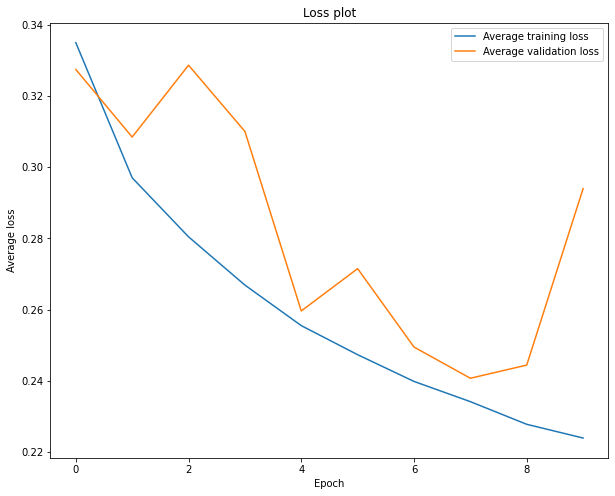

In [24]:
plt.figure(figsize = [10, 8])
plt.plot(history["average_train_loss"],
         label = "Average training loss")
plt.plot(history["average_valid_loss"],
         label = "Average validation loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Average loss")
plt.title("Loss plot")
plt.show()

Visualize the accuracy.

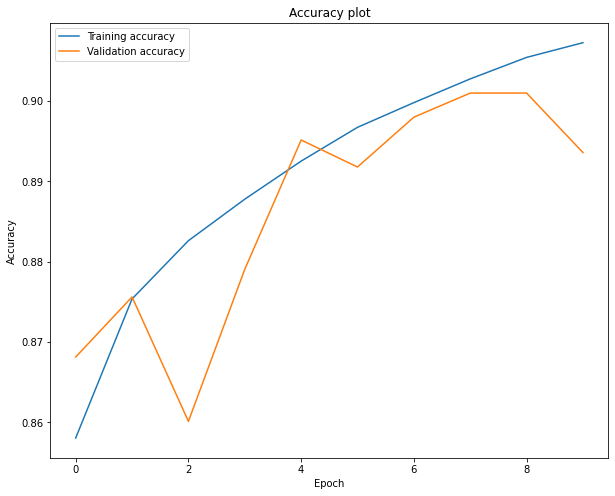

In [25]:
plt.figure(figsize = [10, 8])
plt.plot(history["train_accuracy"],
         label = "Training accuracy")
plt.plot(history["valid_accuracy"],
         label = "Validation accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy plot")
plt.show()

# Evaluate the model

Define the evaluation function.

In [26]:
def evaluate(iterator_test, 
             model, 
             loss_fn,
             device):
    
    size = len(iterator_test.dataset)
    num_batches = len(iterator_test)
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for X, y in iterator_test:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    average_loss = test_loss / num_batches
    accuracy = correct / size
    
    print("Test error:")
    print(f"Accuracy: {accuracy:.6f}, Average loss: {average_loss:.6f}")

Evaluate the model.

In [27]:
evaluate(iterator_test = iterator_test,
         model = model,
         loss_fn = loss_fn,
         device = device)

Test error:
Accuracy: 0.895579, Average loss: 0.292813


# Save the model

Save the model to disk.

In [28]:
torch.save(model, 
           "pytorch-vgg16-cifar-10-model.pth")